In [40]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from skimage import color
import tensorflow as tf
from skimage.feature import hog
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [6]:
# Check for GPU availability
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print('GPU is available')
else:
    print('No GPU detected')

num_gpus = len(physical_devices)

if num_gpus > 0:
    print(f"Number of available GPUs: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {tf.config.experimental.get_device_details(physical_devices[0])}")
else:
    print("No GPUs available")

device = tf.device('gpu:0' if len(physical_devices) > 0 else 'cpu:0')

GPU is available
Number of available GPUs: 1
GPU 0: {'device_name': 'NVIDIA GeForce RTX 3060 Ti', 'compute_capability': (8, 6)}


In [7]:
# Function to extract HOG features from an image
def extract_hog_features(image):
    gray_image = color.rgb2gray(image)
    features, _ = hog(gray_image, visualize=True)
    return features

In [8]:
# Load the dataset using the provided code
data_dir = 'd:\\Rice_Image_Dataset\\Dataset\\Dataset'
train_data = image_dataset_from_directory(data_dir, validation_split=0.1, subset='training', seed=1, shuffle=True, batch_size=64, image_size=(128, 128))

Found 500 files belonging to 5 classes.
Using 450 files for training.


In [9]:
# Create a feature extractor using MobileNetV2
base_model = MobileNetV2(include_top=False, input_shape=(128, 128, 3))
base_model.trainable = True

In [10]:
# Create a new model by adding a Global Average Pooling layer on top of the MobileNetV2 base
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
])

In [11]:
# Extract HOG features from the training set
train_features = []
train_labels = []

In [41]:
# Create a Pandas DataFrame with features
feature_names = [f'feature_{i}' for i in range(train_features.shape[1])]
df = pd.DataFrame(data=train_features, columns=feature_names)
df['label'] = train_labels

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix using seaborn heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [12]:
for images, labels in train_data:
    features = []
    for image in images.numpy():
        hog_features = extract_hog_features(image)
        features.append(hog_features)
    train_features.extend(features)
    train_labels.extend(labels.numpy())


In [13]:
# Convert to NumPy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)


In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)


In [15]:
# Train an SVM classifier
svm_classifier = svm.SVC(kernel='linear', probability=True)
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [16]:
# Predict probabilities on the test set for ROC curve
y_probs = svm_classifier.predict_proba(X_test)[:, 1]

In [17]:
# Predict on the test set
y_pred = svm_classifier.predict(X_test)

In [21]:
# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.9777777777777777
Precision: 0.9788781535158346
Recall: 0.9777777777777777
F1 Score: 0.9772663139329805


In [28]:
# Binarize labels for multiclass ROC curve
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

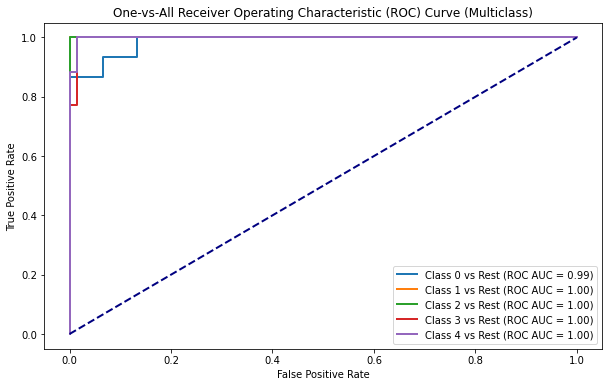

In [30]:
y_probs = svm_classifier.predict_proba(X_test)

# Plot ROC curve for each class against the rest
plt.figure(figsize=(10, 6))
for i in range(len(np.unique(y_test))):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} vs Rest (ROC AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-All Receiver Operating Characteristic (ROC) Curve (Multiclass)')
plt.legend(loc='lower right')
plt.show()

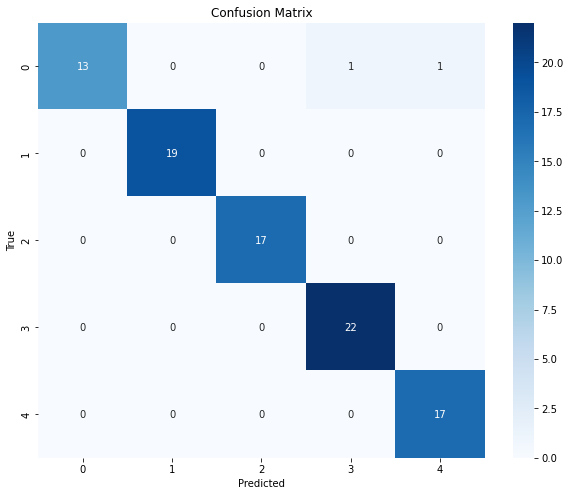

In [37]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()